In [1]:
## Necessary modules
import sys
sys.path.append('/home/norm/Thy_workspace/market_status')
import os
os.chdir("/home/norm/Thy_workspace/market_status")
from ultils.general_helper_functions import *
from ultils.preprocess_utils import *
from ultils.model_helper_functions import *
from ultils.custom_model import *
import torch.utils.data as Data
from torch.utils import data
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
# Check devices
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
from sklearn.metrics import precision_recall_curve
def precision_recall_curve_plot(Y_test, prdict_proba_class1):
    precisions, recalls, thresholds = precision_recall_curve(Y_test, prdict_proba_class1)
    
    plt.figure(figsize=[7,7])
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--',label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    start ,end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    
    plt.xlabel('Threshold value')
    plt.title('Precision & Recall value')
    plt.legend()
    plt.show()

## Load dataset and mapper

In [3]:
testing = pd.read_csv('data/data_classifier_full_feature_07_04_testing.csv')
mapper = load_pickle('model/mapper_fulfill_classifier_07_04.pkl')

In [4]:
print(testing['order_created_at'].max())
print(testing['order_created_at'].min())

2020-04-06T03:21:41.943527+00:00
2020-04-01T01:52:51.181860+00:00


In [5]:
df_testing = testing.groupby('order_id') \
  .apply(lambda x: pd.Series({
      'driver_match': x[(x['bid_price'] <= x['unit_price'])&(x['evan_booking_id'] > 0)]['driver_id'].nunique()
  })
).reset_index()

data_testing = pd.merge(testing, df_testing, on = 'order_id')
data_testing.loc[(data_testing['driver_match'] >= 1),'bidding_status'] = 1
data_testing.loc[(data_testing['driver_match'] == 0),'bidding_status'] = 0

In [6]:
y = data_testing['bidding_status']
df_testing = mapper.fit_transform(data_testing)

In [7]:
import torch.utils.data as Data
from torch.utils import data
import torch
catf, numf = split_features(df_testing)
testds = RegressionColumnarDataset(df_testing, catf, y)
testdl = data.DataLoader(testds, batch_size=len(testds))

In [8]:
model = load_checkpoint('model/embedding_classifier_crossentropy_checkpoint_seed_720_0.9_04_07_2020.pth')
#                         embedding_classifier_crossentropy_checkpoint_seed_7200.836206896551724104-07-2020-09:47.pth')
#                         embedding_classifier_crossentropy_checkpoint_seed_720_0.8962_04_07_2020.pth')

In [9]:
pred = predict_model(testdl, model)

In [10]:
target_proba = to_numpy(pred.T[1])
prob, class_ = torch.max(pred.data, dim = 1)

In [11]:
data_testing['shipment_prob'] = target_proba
data_testing['y_true'] = y
data_testing['prob_predicted'] = prob
data_testing['class_predicted'] = class_

F1:  0.9655172413793104
Acuracy:  0.9333333333333333
Precision:  1.0
Recall:  0.9333333333333333


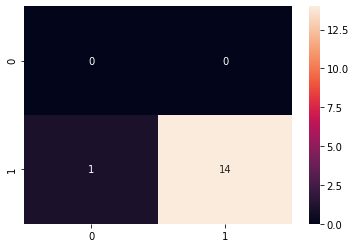

In [12]:
cmdf=pd.DataFrame(confusion_matrix(y,class_),columns=[0,1],index=[0,1])
sns.heatmap(cmdf,annot=True)

print('F1: ',f1_score(y,class_))
print('Acuracy: ',accuracy_score(y,class_))
print('Precision: ',precision_score(y,class_))
print('Recall: ',recall_score(y,class_))